<h1> Objective </h1>
<blockquote>
    
Predict the class of breast cancer (malignant or ‘bad’ versus benign or ‘good’) from the features of images taken from breast samples.
    
</blockquote>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
sns.set()

<h2> Loading in dataset </h2>


In [2]:
cancer_df =  pd.read_csv('data/cancer.data', sep=",",header=None)

<h2> Examining the dataset </h2>


In [3]:
cancer_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
#Adding names to all of the columns
cancer_df.rename(columns = {0: 'Sample code number', 1: 'Clump Thickness', 2: 'Uniformity of Cell Size'
                            , 3: 'Uniformity of Cell Shape', 4: 'Marginal Adhesion', 5: 'Single Epithelial Cell Size'
                            , 6: 'Bare Nuclei', 7: 'Bland Chromatin', 8: 'Normal Nucleoli', 9: 'Mitoses'
                            , 10: 'Class'}, inplace = True)

In [5]:
#Change values in class column as it would be easier to work with them as ones and zeros
cancer_df['Class'] = cancer_df['Class'].map({2: 0, 4: 1})

In [6]:
#looking for null values
cancer_df.isnull().sum()

Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

There aren't any null values or empty columns.

In [7]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Sample code number           699 non-null    int64 
 1   Clump Thickness              699 non-null    int64 
 2   Uniformity of Cell Size      699 non-null    int64 
 3   Uniformity of Cell Shape     699 non-null    int64 
 4   Marginal Adhesion            699 non-null    int64 
 5   Single Epithelial Cell Size  699 non-null    int64 
 6   Bare Nuclei                  699 non-null    object
 7   Bland Chromatin              699 non-null    int64 
 8   Normal Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  Class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [8]:
cancer_df.drop(['Sample code number'],axis=1,inplace=True)

<blockquote>

All the columns are of type integer execpt for Bare Nuclei. I'm going to inspect that colunm and change the data type to int64. As the logistic regression model only accepts integers. The first column *Sample code number* which is the ID column I'll drop as it won't give us any information as to how to predict the class of breast cancer.

</blockquote>


In [9]:
# Replace the '?'s with NaN
cancer_df["Bare Nuclei"].replace('?', np.nan, inplace = True)
cancer_df.isnull().sum()

Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

<blockquote>
    The data contains <b>"?"</b> in the Bare Nuclei column which will create a problem when we try and build a model as a logistic regression model can only be built with numeric data types. So I'll replace the question marks with <b>Nan</b> values and then fill them with the mode value.
    </blockquote>

In [10]:
cancer_df.fillna({"Bare Nuclei":cancer_df["Bare Nuclei"].value_counts().index[0]}, inplace=True)

In [11]:
cancer_df.isnull().sum()

Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [12]:
cancer_df = cancer_df.astype({"Bare Nuclei": int})

<h2> Feature Selection </h2>


<blockquote>
            <b>Correlation and p-value</b> as part of my feature selection process I'll look at the correlation between the independant variables with the dependant variable. Then I examine whether or not that vlaue is statistically significant. Where p-value>0.005 means that the correlation between the target and dependant variable is not statistically significant. The higher the correlation the better it is to use to model. The lower the p-value the greater the statistical significance of that relationship.

</blockquote>

In [13]:
pd.DataFrame([stats.pearsonr(cancer_df[x], cancer_df['Class']) for x in cancer_df.columns]
             , columns=['Correlation', 'P-Value'], index=cancer_df.columns).sort_values(by='P-Value', ascending=True)

,Correlation,P-Value
Class,1.000000,0.000000e+00
Bare Nuclei,0.818968,2.775979e-170
Uniformity of Cell Shape,0.818934,2.945621e-170
Uniformity of Cell Size,0.817904,1.747924e-169
Bland Chromatin,0.756616,9.849140e-131
Clump Thickness,0.716001,6.835566e-111
Normal Nucleoli,0.712244,3.124155e-109
Marginal Adhesion,0.696800,1.109757e-102
Single Epithelial Cell Size,0.682785,4.346160e-97
Mitoses,0.423170,9.682098e-32


<blockquote>
    I have chosen 0.6 as my correlation threshold. As from 6 we have moderate for very high correlation and I think that would be the best to use. Setting the threshold any lower might make me end up including values that don't add any value to the model and create noise. So because of that I will not include Mitoses as one of the features in my model because the correlation with Class is too low. All the other values okay to consider modelling with.

</blockquote>

<blockquote>
            But before I use all these features I need to check for <b>Multicollinearities</b> and remove them so that I don't end up overfitting as a result of them. For that I will be using the variance inflation factor. Where any value over 5 means that theres an interdependance between the independant variables and they therefore contain multicollinearities.

</blockquote>

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Calculating VIF
vif = pd.DataFrame()
vif["variables"] = cancer_df.columns[:-2]
vif["VIF"] = [variance_inflation_factor(cancer_df[cancer_df.columns[:-2]].values, i) 
              for i in range(cancer_df[cancer_df.columns[:-2]].shape[1])]

vif

,variables,VIF
0,Clump Thickness,5.120359
1,Uniformity of Cell Size,13.945552
2,Uniformity of Cell Shape,14.070698
3,Marginal Adhesion,4.756558
4,Single Epithelial Cell Size,6.359212
5,Bare Nuclei,4.804216
6,Bland Chromatin,7.495019
7,Normal Nucleoli,4.499257


<blockquote>
    From looking at this we can see that clump Clump Thickness, Uniformity of Cell Size, Uniformity of Cell Shape, Single Epithelial Cell Size and Bland Chromatin all have multicollinearities. I dropped all the attributes one by one starting from highest to lowest. Removing all of them all at once would not be a good idea as when you remove in attribute after I drop one attribute it might take away the multicollinearity in another. This way I maintain more attributes and am able to feed the model more information to the model.
    </blockquote>

In [15]:
cancer_df.drop(['Uniformity of Cell Size', 'Uniformity of Cell Shape','Bland Chromatin','Single Epithelial Cell Size'],axis=1, inplace=True)

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Calculating VIF
vif = pd.DataFrame()
vif["variables"] = cancer_df.columns[:-2]
vif["VIF"] = [variance_inflation_factor(cancer_df[cancer_df.columns[:-2]].values, i) 
              for i in range(cancer_df[cancer_df.columns[:-2]].shape[1])]

vif

,variables,VIF
0,Clump Thickness,3.709679
1,Marginal Adhesion,4.015137
2,Bare Nuclei,4.280747
3,Normal Nucleoli,3.471669


<blockquote>
    After removing Uniformity of Cell Size, Uniformity of Cell Shape, Bland Chromatin, Single Epithelial Cell Size the value of Clump thickness has dropped from 5.120359 to 3.709679. So that along with the remaining values in the above dataframe is what I will use to model. 
    </blockquote>

<h1> Splitting Data </h1>

In [17]:
x = cancer_df[['Marginal Adhesion','Bare Nuclei','Normal Nucleoli','Clump Thickness']]
y = cancer_df['Class']

In [18]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.35,random_state=1)

<h1> Modelling </h1>

In [19]:
LogReg = LogisticRegression(random_state=1, solver='lbfgs').fit(x_train, y_train)

In [20]:
test_pred = LogReg.predict(x_test)
train_pred = LogReg.predict(x_train)

print("Test acurracy {}".format(accuracy_score(y_test,test_pred)))
print("Train acurracy {}".format(accuracy_score(y_train,train_pred)))

Test acurracy 0.9551020408163265
Train acurracy 0.9669603524229075


<blockquote>
The model has an Test acurracy 0.9551020408163265 and Train acurracy 0.9669603524229075. This means that it has a very high accuracy and is performing really well. There are no signs of overfitting as the test and train accuracy scores don't have a very wide variance. There's no signs of underfitting as the train accuracy is higher than the test accuracy which is expected because the this is the data that the model learnt on and has seen before so it should be better at predicting that. 
    </blockquote>

In [21]:
def matrix(actual,predicted):
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names,va="center")
    plt.yticks(tick_marks, class_names,va="center")
    # create heatmap
    sns.heatmap(pd.DataFrame(confusion_matrix(actual, predicted)), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    ax.set(yticks=[0, 2], 
           xticks=[0, 1], 
           yticklabels=class_names, 
           xticklabels=class_names)
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

   <h2>Test Confusion Matrix</h2>


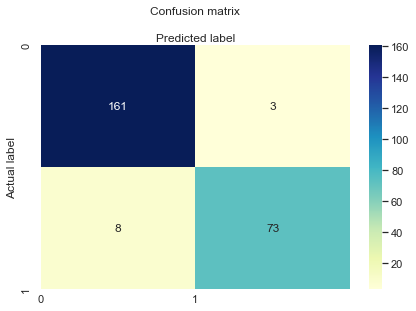

In [22]:
matrix(y_test, test_pred)

<blockquote>
We have <b>161 True Positives</b> and there are <b>3 False Positive</b>. We have <b>8 False Negatives</b>, and there are <b>73  True Negatives</b>. Overall the model is classifying more values correctly than incorrectly, therefore it is performing well.
</blockquote>

 <h2>Train Confusion Matrix</h2>


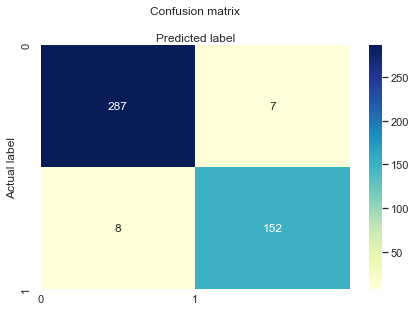

In [23]:
matrix(y_train, train_pred)

<blockquote>
We have <b>287 True Positives</b> and there are <b>7 False Positives</b>. We have <b>8 False Negatives</b>, and there are <b>152 True Negative</b>. Overall the model is classifying more values correctly than incorrectly, therefore it is performing well.
</blockquote>

<h2>Test Classification Report</h2>


In [24]:
print(classification_report(y_test, test_pred, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.95      0.98      0.97       164
   Malignant       0.96      0.90      0.93        81

    accuracy                           0.96       245
   macro avg       0.96      0.94      0.95       245
weighted avg       0.96      0.96      0.95       245



<blockquote>

It has a precision score 0.95 for benign tumors meaning that 95% of the predicted cases were correct. It has a precision score 0.96 for malignant tumors meaning that 96% of the predicted cases were correct. The recall score is 0.97 for benign tumors meaning that 97% of the observed cases were correctly predicted.The recall score is 0.90 for malignant tumors meaning that 90% of the observed cases were correctly predicted. We have an f1 score of 0.97 for beninging tumors and 0.93 for malignant tumors. Overall looking at these scores we can see that the model is performing very well. I have high precision and high recall meaning that the model will perform well and correctly classify the class of cancer. So where people have people have benign or malignant cancer types the model will actually classify them correctly. 

</blockquote>

<h2>Train Classification Report</h2>


In [25]:
print(classification_report(y_train, train_pred, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.97      0.98      0.97       294
   Malignant       0.96      0.95      0.95       160

    accuracy                           0.97       454
   macro avg       0.96      0.96      0.96       454
weighted avg       0.97      0.97      0.97       454



<blockquote>

It has a precision score 0.97 for benign tumors meaning that 97% of the predicted cases were correct. It has a precision score of 0.96 for malignant tumors meaning that 96% of the predicted cases were correct. The recall score is 0.98 for benign tumors meaning that 98% of the observed cases were correctly predicted.The recall score is 0.95 for malignant tumors meaning that 95% of the observed cases were correctly predicted. We have an f1 score of 0.97 for beninging tumors and 0.95 for malignant tumors. Overall looking at these scores we can see that the model is performing very well. I have high precision and high recall meaning that the model will perform well and correctly classify the class of cancer. So where people have people have benign or malignant cancer types the model will actually classify them correctly. 

</blockquote>

In [26]:
def curve(actual,predicted):    
    logit_roc_auc = roc_auc_score(actual,predicted)
    fpr, tpr, thresholds = roc_curve(y_test, LogReg.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

<h2>Test ROC Curve</h2>


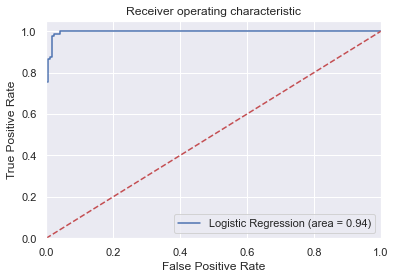

In [27]:
curve(y_test,test_pred)

<blockquote>
    Looking at the ROC curve and the area = 0.94 under the ROC curve we can see that the model is performing very well.

</blockquote>

<h2>Train ROC Curve</h2>


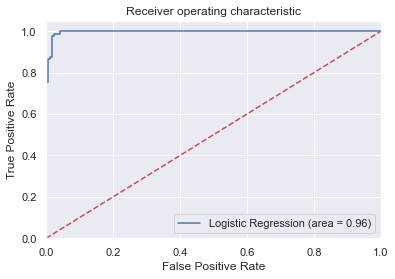

In [28]:
curve(y_train, train_pred)

<blockquote>
    Looking at the ROC curve and the area = 0.96 under the ROC curve we can see that the model is performing very well. It makes sense for this score to be higher as this is the data the model has seen before and was trained on. So it would predict it more accura

</blockquote>

<h1>Overdispersion</h1>


<blockquote>
    Overdispersion is the presence of greater variability (statistical dispersion) in a data set than would be expected based on a given statistical model. When the variance is greater than the mean we can say that there is overdispersion.
    </blockquote>

<h2>Overdispersion Test Data</h2>


In [29]:
print("Variance % s" %(statistics.variance(test_pred)))

Variance 0


In [30]:
print("Mean % s" %(statistics.mean(test_pred)))

Mean 0


<blockquote>
In this case there is no overdispersion as mean = variance. Meaning that the model is displaying the amount of variance expected.
</blockquote>

<h2>Overdispersion Train Data</h2>


In [31]:
print("Variance % s" %(statistics.variance(train_pred)))

Variance 0


In [32]:
print("Mean % s" %(statistics.mean(train_pred)))

Mean 0


<blockquote>
In this case there is no overdispersion as mean = variance. Meaning that the model is displaying the amount of variance expected.
</blockquote>